In [49]:
# Importing Important libraries for data.
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
!pip install pandas-ta
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

# Load S&P 500 data
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-') # Replace the '.' with '-', otherwise we will get an error while downloading the data.
symbols_list = sp500['Symbol'].unique().tolist() # Create a list of Symbols of snp500.

# Define date range
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Download stock data from Yahoo Finance
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['SW', 'GEV', 'SOLV', 'VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


In [50]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375282   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718933   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145809   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[984472 rows x 6 columns]

In [51]:
# Calculate Garman-Klass volatility
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)
# Add RSI, Bollinger Bands, ATR, MACD
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375282   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718933   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145809   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001156        NaN       NaN   
           AAPL    293461600.0         -0.005949        NaN       NaN   
           ABBV     12842800.0         -0.059780        NaN       NaN   
           ABT      12287500.0         -0.010671        NaN       NaN   
           ACGL      1888800.0          0.000068        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000058  26.146743  4.483137   
           YUM       1500600.0         -0.000213  36.057148  4.801976   
           ZBH       3610500.0         -0.000058  31.893206  4.743683   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000032  42.623478  5.151393   

Price                bb_mid   bb_high  
date       ticker                      
2015-09-29 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2023-09-26 XYL     4.565058  4.646979  
           YUM     4.831939  4.861902  
           ZBH     4.783349  4.823015  
           ZBRA    5.539167  5.677342  
           ZTS     5.210205  5.269017  

[984472 rows x 11 columns]

In [52]:
# Compute ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Compute MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
# Dollar volume calculation
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375282   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718933   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145809   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.501099   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001156        NaN       NaN   
           AAPL    293461600.0         -0.005949        NaN       NaN   
           ABBV     12842800.0         -0.059780        NaN       NaN   
           ABT      12287500.0         -0.010671        NaN       NaN   
           ACGL      1888800.0          0.000068        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000058  26.146743  4.483137   
           YUM       1500600.0         -0.000213  36.057148  4.801976   
           ZBH       3610500.0         -0.000058  31.893206  4.743683   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000032  42.623478  5.151393   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.669686  
           AAPL         NaN       NaN       NaN       NaN    7217.856330  
           ABBV         NaN       NaN       NaN       NaN     458.731114  
           ABT          NaN       NaN       NaN       NaN     407.279130  
           ACGL         NaN       NaN       NaN       NaN      46.118202  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.565058  4.646979  0.033800 -2.159189     117.033853  
           YUM     4.831939  4.861902  0.142547 -1.363696     181.599378  
           ZBH     4.783349  4.823015 -0.381708 -0.881067     401.803403  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.210205  5.269017  0.651515 -1.188278     255.646086  

[984472 rows x 14 columns]

In [53]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
# Resample data and filter for top dollar volume stocks
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.525150   38.888988         -0.002190  73.421460   
           AAPL      4014.914493   26.793613         -0.003473  55.537349   
           ABBV       331.841258   39.708744         -0.064880  49.376854   
           ABT        209.554449   37.912792         -0.012576  56.962447   
           ACGL        29.629264   24.156668          0.000078  35.682541   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000          0.000214  41.544692   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.304721  107.661484          0.000080  55.245457   
           GEHC       212.127119   66.083885          0.000184  40.922344   
           KVUE       664.360284   19.814009         -0.000410  35.706365   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.542646  3.615088  3.687530 -1.033887  0.567157  
           AAPL    3.279507  3.322815  3.366124 -0.967900 -0.142789  
           ABBV    3.710011  3.758240  3.806469 -0.526809  0.145677  
           ABT     3.646322  3.668170  3.690018 -1.064842  0.335556  
           ACGL    3.226274  3.243525  3.260776 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.650304  4.690476  4.730649 -0.436215  0.366876  
           GEHC    4.154746  4.212281  4.269817 -0.893478 -1.116463  
           KVUE    3.005097  3.080010  3.154924 -0.899746 -1.435620  

[46483 rows x 9 columns]

In [54]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank'] < 150]

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-10-31 AAPL      3816.041198   26.153399         -0.002611  49.891131   
           ABBV       331.556416   39.562855         -0.051416  27.477676   
           ABT        300.211907   33.952461         -0.008608  38.008768   
           ACN        244.043382  102.699371         -0.005388  53.823667   
           ADBE       257.607725  107.510002          0.000059  53.668389   
...                          ...         ...               ...        ...   
2023-09-30 MRNA      1327.769236   98.120003          0.000146  38.747314   
           UBER       907.460732   44.270000          0.000441  45.005268   
           CRWD       633.457111  160.479996          0.000144  51.534803   
           PLTR       920.364061   13.960000          0.000214  41.544692   
           ABNB       909.311388  132.279999          0.000213  44.494127   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-10-31 AAPL    3.292064  3.320942  3.349819 -1.038688 -0.195978   
           ABBV    3.736752  3.790895  3.845038 -0.893132 -0.760594   
           ABT     3.544925  3.595386  3.645846 -1.035224 -0.650889   
           ACN     4.628986  4.640623  4.652259 -0.996806 -0.135456   
           ADBE    4.679513  4.694639  4.709766 -1.230331 -0.109039   
...                     ...       ...       ...       ...       ...   
2023-09-30 MRNA    4.582514  4.685332  4.788149 -0.529511 -0.376899   
           UBER    3.806654  3.862227  3.917801 -0.746098 -0.133973   
           CRWD    5.026187  5.103696  5.181204 -0.744862  0.245950   
           PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581   
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854   

                   dollar_vol_rank  
date       ticker                   
2016-10-31 AAPL                1.0  
           ABBV               67.0  
           ABT                78.0  
           ACN               100.0  
           ADBE               95.0  
...                            ...  
2023-09-30 MRNA               18.0  
           UBER               38.0  
           CRWD               63.0  
           PLTR               36.0  
           ABNB               37.0  

[12516 rows x 10 columns]

In [55]:
# Calculate returns for different time lags
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-10-31 AAPL      3713.452399   39.624393         -0.001153  69.196710   
           ABBV       331.785844   66.346992         -0.038051  55.247875   
           ABT        289.738760   48.011196         -0.006128  53.844951   
           ACN        244.526571  128.312439         -0.004612  69.365380   
           ADBE       292.749658  175.160004          0.000067  70.089317   
...                          ...         ...               ...        ...   
2023-09-30 MRNA      1327.769236   98.120003          0.000146  38.747314   
           UBER       907.460732   44.270000          0.000441  45.005268   
           CRWD       633.457111  160.479996          0.000144  51.534803   
           PLTR       920.364061   13.960000          0.000214  41.544692   
           ABNB       909.311388  132.279999          0.000213  44.494127   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-10-31 AAPL    3.592536  3.639405  3.686275 -0.906642 -0.039276   
           ABBV    4.179863  4.226212  4.272562  0.375557  0.473816   
           ABT     3.882779  3.906344  3.929909 -1.040044  0.276133   
           ACN     4.794306  4.833983  4.873660 -0.986514  0.352342   
           ADBE    4.951759  5.089292  5.226825 -0.888269  0.612102   
...                     ...       ...       ...       ...       ...   
2023-09-30 MRNA    4.582514  4.685332  4.788149 -0.529511 -0.376899   
           UBER    3.806654  3.862227  3.917801 -0.746098 -0.133973   
           CRWD    5.026187  5.103696  5.181204 -0.744862  0.245950   
           PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581   
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854   

                   dollar_vol_rank  return_1m  return_2m  return_3m  \
date       ticker                                                     
2017-10-31 AAPL                1.0   0.096808   0.015250   0.044955   
           ABBV               70.0   0.022728   0.098590   0.091379   
           ABT                83.0   0.021276   0.034308   0.034801   
           ACN               106.0   0.064180   0.048455   0.037203   
           ADBE               80.0   0.174152   0.062497   0.061392   
...                            ...        ...        ...        ...   
2023-09-30 MRNA               18.0  -0.132219  -0.086803  -0.068763   
           UBER               38.0  -0.062672  -0.053920   0.008422   
           CRWD               63.0  -0.015641  -0.003656   0.029981   
           PLTR               36.0  -0.068091  -0.161174  -0.030723   
           ABNB               37.0   0.005549  -0.067704   0.010603   

                   return_6m  return_9m  return_12m  
date       ticker                                    
2017-10-31 AAPL     0.028875   0.038941    0.035228  
           ABBV     0.056495   0.047273    0.044026  
           ABT      0.038672   0.031320    0.029294  
           ACN      0.028692   0.027398    0.018728  
           ADBE     0.045993   0.049515    0.041515  
...                      ...        ...         ...  
2023-09-30 MRNA    -0.071952  -0.064976   -0.015431  
           UBER     0.057244   0.066838    0.043691  
           CRWD     0.026391   0.047942   -0.002216  
           PLTR     0.087272   0.090143    0.046083  
           ABNB     0.010289   0.049124    0.019401  

[10344 rows x 16 columns]

In [56]:
# Download Fama-French factors
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.36,0.34,0.43,-1.27,0.46
2010-02-01,3.40,1.51,3.22,-0.27,1.42
2010-03-01,6.31,1.85,2.21,-0.65,1.69
2010-04-01,2.00,4.98,2.89,0.69,1.72
2010-05-01,-7.89,0.05,-2.44,1.30,-0.22
...,...,...,...,...,...
2024-06-01,2.77,-4.37,-3.31,0.51,-1.78
2024-07-01,1.24,8.28,5.74,0.22,0.43
2024-08-01,1.61,-3.65,-1.13,0.85,0.86


In [57]:
# Make both indices tz-naive before joining
factor_data.index = factor_data.index.tz_localize(None)
data.index = pd.MultiIndex.from_tuples(
    [(date.tz_localize(None), ticker) for date, ticker in data.index],
    names=['date', 'ticker']
)

# Resample factor data to match the monthly frequency of `data`
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

# Join factor data and stock return data
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.096808
           ABBV    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.022728
           ABT     0.0225 -0.0194  0.0019  0.0091 -0.0326   0.021276
           ACN     0.0225 -0.0194  0.0019  0.0091 -0.0326   0.064180
           ADBE    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WDAY   -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.062413
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[10344 rows x 6 columns]

In [58]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.329037 -0.163596  0.272318  0.320803  0.096978
           WDAY    1.085504 -0.908080 -0.596800 -0.906440 -0.196881
           WFC     1.112946  0.306859  2.044026 -0.451835 -1.511412
           WMT     0.703224 -0.309990 -0.427582 -0.156628  0.526795
           XOM     0.972448 -1.081440  1.740413 -0.634737 -0.371115

[10327 rows x 5 columns]

In [59]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.drop('dollar_volume', axis=1)

data = data.drop('dollar_vol_rank', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10093 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10093 non-null  float64
 1   rsi               10093 non-null  float64
 2   bb_low            10093 non-null  float64
 3   bb_mid            10093 non-null  float64
 4   bb_high           10093 non-null  float64
 5   atr               10093 non-null  float64
 6   macd              10093 non-null  float64
 7   return_1m         10093 non-null  float64
 8   return_2m         10093 non-null  float64
 9   return_3m         10093 non-null  float64
 10  return_6m         10093 non-null  float64
 11  return_9m         10093 non-null  float64
 12  return_12m        10093 non-null  float64
 13  Mkt-RF            10093 non-null  float64
 14  SMB               10093 non-null  float64
 15  HML      

In [66]:
from sklearn.cluster import KMeans

# Drop 'cluster' column if it exists
data = data.drop('cluster', axis=1, errors='ignore')

def get_clusters(df):
    # Perform KMeans clustering and assign the cluster labels to a new 'cluster' column
    df['cluster'] = KMeans(n_clusters=4, random_state=0,init=
initial_centroids).fit(df).labels_
    return df

# Apply clustering on non-NaN data grouped by 'date'
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001153  69.196710  3.592536  3.639405  3.686275   
           ABBV           -0.038051  55.247875  4.179863  4.226212  4.272562   
           ABT            -0.006128  53.844951  3.882779  3.906344  3.929909   
           ACN            -0.004612  69.365380  4.794306  4.833983  4.873660   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000103  54.722553  3.980011  3.997479  4.014947   
           XOM            -0.000205  59.440201  4.679146  4.719239  4.759332   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906642 -0.039276   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473816   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048455   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276810 -0.274815   
           ABBV     0.056495   0.047273    0.044026  0.499079  0.359312   
           ABT      0.038672   0.031320    0.029294  0.829184 -0.188544   
           ACN      0.028692   0.027398    0.018728  1.197552 -0.163036   
           ADBE     0.045993   0.049515    0.041515  1.114761 -0.330562   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743593 -0.256719   
           XOM      0.012838   0.008747    0.027037  0.996161 -1.039314   
           MRNA    -0.071952  -0.064976   -0.015431  1.158937  0.746553   
           UBER     0.057244   0.066838    0.043691  1.090266  1.140600   
           CRWD     0.026391   0.047942   -0.002216  0.604910 -0.960057   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.585546  0.639676  0.443303        3  
           ABBV   -0.032822  0.212866  0.172831        2  
           ABT    -0.540950  0.257528  0.978615        2  
           ACN    -0.326805  0.271910  0.164495        3  
           ADBE   -0.170804 -0.218007 -0.696377        3  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.535741 -0.139709  0.661321        2  
           XOM     1.691437 -0.669415 -0.285603        3  
           MRNA   -1.134033  0.610472  0.970465        1  
           UBER   -0.263071 -1.534224 -0.434869        1  
           CRWD   -0.682940 -2.482535 -0.810270        2  

[10093 rows x 19 columns]

In [67]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

In [68]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

Output hidden; open in https://colab.research.google.com to view.

In [65]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [69]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BLK',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',


In [71]:
!pip install PyPortfolioOpt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 13.8 MB/s eta 0:00:00


In [72]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  155 of 155 completed


Price        Adj Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2016-10-31   26.153397   39.562859  33.952473  102.699387  107.510002   
2016-11-01   25.681187   40.038055  33.788067  102.611023  106.870003   
2016-11-02   25.704226   40.279213  33.485237  104.793304  105.889999   
2016-11-03   25.428709   39.640881  33.208351  103.326668  107.169998   
2016-11-04   25.199490   39.747261  33.822681  103.574059  106.199997   
...                ...         ...        ...         ...         ...   
2023-09-25  174.991058  147.717529  95.036842  310.686279  511.600006   
2023-09-26  170.896545  147.010727  93.827797  304.433136  506.299988   
2023-09-27  169.375977  146.265686  93.145264  308.128174  502.600006   
2023-09-28  169.634384  145.425140  95.670609  294.788849  504.670013   
2023-09-29  170.151154  142.378128  94.432312  301.002747  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2016-10-31   73.081581   72.279999  49.910473   26.555431    7.230000  ...   
2016-11-01   72.964058   70.099998  49.085369   26.391062    7.090000  ...   
2016-11-02   75.532722   68.680000  48.980209   26.107971    6.760000  ...   
2016-11-03   74.987083   67.610001  47.038799   25.815754    6.700000  ...   
2016-11-04   74.777252   69.440002  46.415939   25.770092    6.560000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  233.448486  205.669998  60.502197  135.559128   97.379997  ...   
2023-09-26  230.744598  201.660004  59.654991  133.068069   95.959999  ...   
2023-09-27  235.987030  202.279999  59.411541  134.040680   98.070000  ...   
2023-09-28  236.648392  207.889999  59.674465  137.176819  102.760002  ...   
2023-09-29  233.993149  206.910004  59.012280  137.405106  102.820000  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2016-10-31  4969500  1928200  12459400   4662100  1147300  3363200  20115900   
2016-11-01  7816800  2458200  13229400   5130800  1091400  3821100  20020200   
2016-11-02  7317600  2580400  16488200   9783100  1127800  4216200  19566600   
2016-11-03  3855900  2371000  12605100   4586500   633300  3192600  14982700   
2016-11-04  3729900  1902100  14410200   7023900   892600  2705600  27391600   
...             ...      ...       ...       ...      ...      ...       ...   
2023-09-25  3241900   698100  17616900   6891000   894200  2685900  10624000   
2023-09-26  4936800   633600  18841600   7570500  1217300  3571100  15219400   
2023-09-27  3644000   860600  22083500  10182900  2338100  2547800  11815500   
2023-09-28  3587300   578900  18772100   7291500  9196300  3282000  12454600   
2023-09-29  4302200   896800  19759400  25659100  4066600  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

In [73]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if not success:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        # Fix the column handling by using 'Ticker' instead of 'index'
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True, right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df.head()


Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001408
2017-11-02,0.003003
2017-11-03,0.006417
2017-11-06,0.002645
2017-11-07,0.003143


In [82]:
portfolio_df.tail()

,Strategy Return
date,
2023-09-25,0.003490
2023-09-26,-0.011924
2023-09-27,0.004862
2023-09-28,0.006411
2023-09-29,-0.007087


In [86]:
spy = yf.download(tickers='SPY',
                  start='2017-10-31',
                  end='2023-09-30')  # Changed end date to 2023-09-29

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

spy_ret.tail()


[*********************100%***********************]  1 of 1 completed


Price,SPY Buy&Hold
Ticker,SPY
Date,
2023-09-25,0.004196
2023-09-26,-0.014800
2023-09-27,0.000399
2023-09-28,0.005781
2023-09-29,-0.002430



Performance Summary:
Strategy Total Return: 135.43%
SPY Total Return: 62.42%
Outperformance: 73.01%


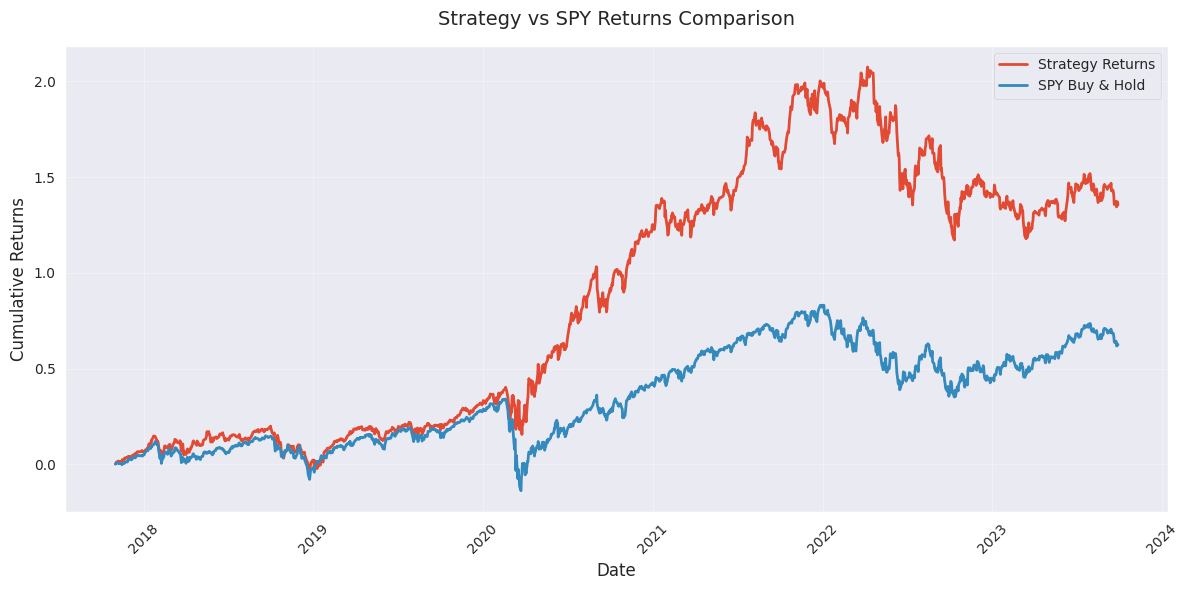

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_strategy_comparison(portfolio_df, spy_ret):
    # Reset index if date is set as index
    portfolio_df = portfolio_df.reset_index() if isinstance(portfolio_df.index, pd.DatetimeIndex) else portfolio_df
    spy_ret = spy_ret.reset_index() if isinstance(spy_ret.index, pd.DatetimeIndex) else spy_ret

    # Convert date columns to datetime if they aren't already
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
    spy_ret['Date'] = pd.to_datetime(spy_ret['Date'])

    # Calculate cumulative returns for both strategies
    portfolio_df['Cumulative_Strategy'] = (1 + portfolio_df['Strategy Return']).cumprod() - 1
    spy_ret['Cumulative_SPY'] = (1 + spy_ret['SPY Buy&Hold']).cumprod() - 1

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.set_style('darkgrid')

    # Plot both lines
    plt.plot(portfolio_df['date'], portfolio_df['Cumulative_Strategy'],
             label='Strategy Returns', linewidth=2)
    plt.plot(spy_ret['Date'], spy_ret['Cumulative_SPY'],
             label='SPY Buy & Hold', linewidth=2)

    # Customize the plot
    plt.title('Strategy vs SPY Returns Comparison', fontsize=14, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Calculate and display some statistics
    strategy_total_return = portfolio_df['Cumulative_Strategy'].iloc[-1]
    spy_total_return = spy_ret['Cumulative_SPY'].iloc[-1]

    print(f"\nPerformance Summary:")
    print(f"Strategy Total Return: {strategy_total_return:.2%}")
    print(f"SPY Total Return: {spy_total_return:.2%}")
    print(f"Outperformance: {(strategy_total_return - spy_total_return):.2%}")

    return plt.gcf()

fig = plot_strategy_comparison(portfolio_df, spy_ret)
plt.show()